In [60]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load and prepare the data

Load csv file named beijingpm.csv, data set are downloaded from https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [61]:
data_path = 'beijingpm.csv'

data = pd.read_csv(data_path)

Have a look of dataframe, attribute information are as follow:
- No: row number 
- year: year of data in this row 
- month: month of data in this row 
- day: day of data in this row 
- hour: hour of data in this row 
- pm2.5: PM2.5 concentration (ug/m^3) 
- DEWP: Dew Point (â„ƒ) 
- TEMP: Temperature (â„ƒ) 
- PRES: Pressure (hPa) 
- cbwd: Combined wind direction 
- Iws: Cumulated wind speed (m/s) 
- Is: Cumulated hours of snow 
- Ir: Cumulated hours of rain 



In [62]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [63]:
data.tail()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0


Let's see a brief info about this data set:

### Cleaning and resizing data
First, let's make year, month, day, hour in year-month-day-hour form and make a plot showing the unscaled pm2.5 over the first 30 days in the data set. (Some days don't have pm2.5 data in the data set, so it's not continuous in plot.)

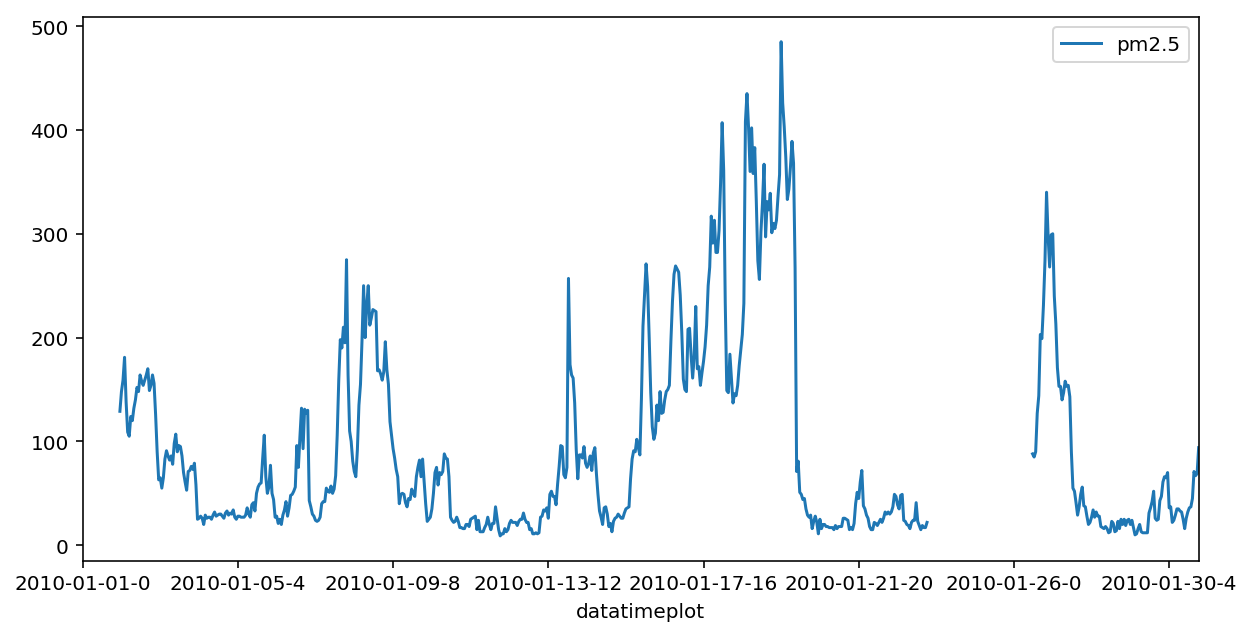

In [64]:
data['datatime'] = data['year'].astype(str) + '-' + data['month'].astype(str) + '-' + data['day'].astype(str)
data['datatime'] = pd.to_datetime(data['datatime'])
data['datatimeplot'] = data['datatime'].astype(str) + '-' + data['hour'].astype(str)
_ = data[:720].plot(x='datatimeplot', y='pm2.5', figsize=(10, 5))

Second, transform cbwd to number representation. There are 4 types of cbwd: NE, NW, SE, cv, let's make them as 1, 2, 3, 4.

In [65]:
# data.groupby('cbwd').count()
data['cbwd'] = data['cbwd'].replace({'NE': '1', 'NW': '2', 'SE': '3', 'cv': '4'})

### Rescaling target variables
To make training the network easier, I'll shift and scale the variables such that they have zero mean and a standard deviation of 1.
The scaling factors are saved so we can go backwards when we use the network for predictions.
Then I will one hot encode month, day, hour and cbwd, and add new feature season accroading to month.

In [66]:
rescale_features = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
# rescale_features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in rescale_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [67]:
# 1 is spring, 2 summer, 3 fall, 4 winter
data['season'] = data['month'].replace({1: '4', 2: '4', 3: '1', 4: '1',
                                        5: '1', 6: '2', 7: '2', 8: '2',
                                        9: '3', 10: '3', 11:'3', 12:'4'})

dummy_fields = ['year', 'month', 'day', 'hour', 'cbwd', 'season']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

# Drop year, month, day, hour, there is no need of such column now
fields_to_drop = ['No', 'year', 'month', 'day', 'hour', 'season', 'datatimeplot', 'datatime', 'cbwd']
pmdata = data.drop(fields_to_drop, axis=1)

Below is a plot showing the rescaled pm2.5 over the first 10 days in the data set. (Some days don't have pm2.5 data in the data set, so it's not exactly 10 days.) 

In [68]:
pmdata.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,year_2010,year_2011,year_2012,...,hour_22,hour_23,cbwd_1,cbwd_2,cbwd_3,cbwd_4,season_1,season_2,season_3,season_4
0,NaN,-1.580860,-1.922229,0.443323,-0.441889,-0.069352,-0.137666,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,NaN,-1.580860,-2.004205,0.345939,-0.379302,-0.069352,-0.137666,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,NaN,-1.580860,-1.922229,0.248556,-0.343510,-0.069352,-0.137666,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,NaN,-1.580860,-2.168158,0.248556,-0.280923,-0.069352,-0.137666,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,NaN,-1.511576,-2.004205,0.151173,-0.218336,-0.069352,-0.137666,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [69]:
pmdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 87 columns):
pm2.5        41757 non-null float64
DEWP         43824 non-null float64
TEMP         43824 non-null float64
PRES         43824 non-null float64
Iws          43824 non-null float64
Is           43824 non-null float64
Ir           43824 non-null float64
year_2010    43824 non-null uint8
year_2011    43824 non-null uint8
year_2012    43824 non-null uint8
year_2013    43824 non-null uint8
year_2014    43824 non-null uint8
month_1      43824 non-null uint8
month_2      43824 non-null uint8
month_3      43824 non-null uint8
month_4      43824 non-null uint8
month_5      43824 non-null uint8
month_6      43824 non-null uint8
month_7      43824 non-null uint8
month_8      43824 non-null uint8
month_9      43824 non-null uint8
month_10     43824 non-null uint8
month_11     43824 non-null uint8
month_12     43824 non-null uint8
day_1        43824 non-null uint8
day_2        43824 non-null

### Splitting the data into training, testing, and validation sets
Data is ranged from `2010-01-01` to `2014-12-31`, with 43824 instances in total. There are 2067 instances in this data set missed its pm2.5 true value, thus those instances can not be used as training sample.

We'll save the data for the last approximately 45 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [70]:
# Save data for the last 45 days 
test_data = pmdata[-45*24:]
# Now remove the test data from the data set and remove those whose pm2.5 is 'NaN' 
pmdata = pmdata[:-45*24]
print('There are {} instances remained, and {} for test.'.format(len(pmdata), len(test_data)))
pmdata = pmdata.dropna()
print('There are {} instances remained after reomve nan for training.'.format(len(pmdata)))
# Separate the data into features and targets
target_fields = ['pm2.5']
features, targets = pmdata.drop(target_fields, axis=1), pmdata[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

There are 42744 instances remained, and 1080 for test.
There are 40717 instances remained after reomve nan for training


Split the data into two sets, one for training and one for validating as the network is being trained.

In [71]:
# Hold out the last 200 * 24 hours or so of the remaining data as a validation set, the NaN instances is already droped
train_features, train_targets = features[:-200*24], targets[:-200*24]
val_features, val_targets = features[-200*24:], targets[-200*24:]
print('There are {} instances for training and {} instances for valadation.'
      .format(len(train_features), len(val_features)))
print('There are {} instances for training and {} instances for valadation.'
      .format(len(train_targets), len(val_targets)))

There are 35917 instances for training and 4800 instances for valadation.
There are 35917 instances for training and 4800 instances for valadation.


## 2. Build the network
Below block is for building network. I've built out the structure and the backwards pass.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid(try relu later) function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is  f(x)=xf(x)=x . All of the outputs from one layer become inputs to the neurons on the next layer. This process is called forward propagation.

In [72]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
            Arguments
            ---------
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            ### Forward pass ###
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            ### Backward pass ###
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            hidden_error = np.dot(error, self.weights_hidden_to_output.T)
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        # Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
            Arguments
            ---------
            features: 1D array of feature values
        '''
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer  
        return final_outputs

In [73]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 3. Training the network

In [76]:
import sys

### Set the hyperparameters here ###
iterations = 8000
learning_rate = 0.70
hidden_nodes = 28
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=256)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['pm2.5']                           
    network.train(X, y)
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['pm2.5'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['pm2.5'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.449 ... Validation loss: 0.391

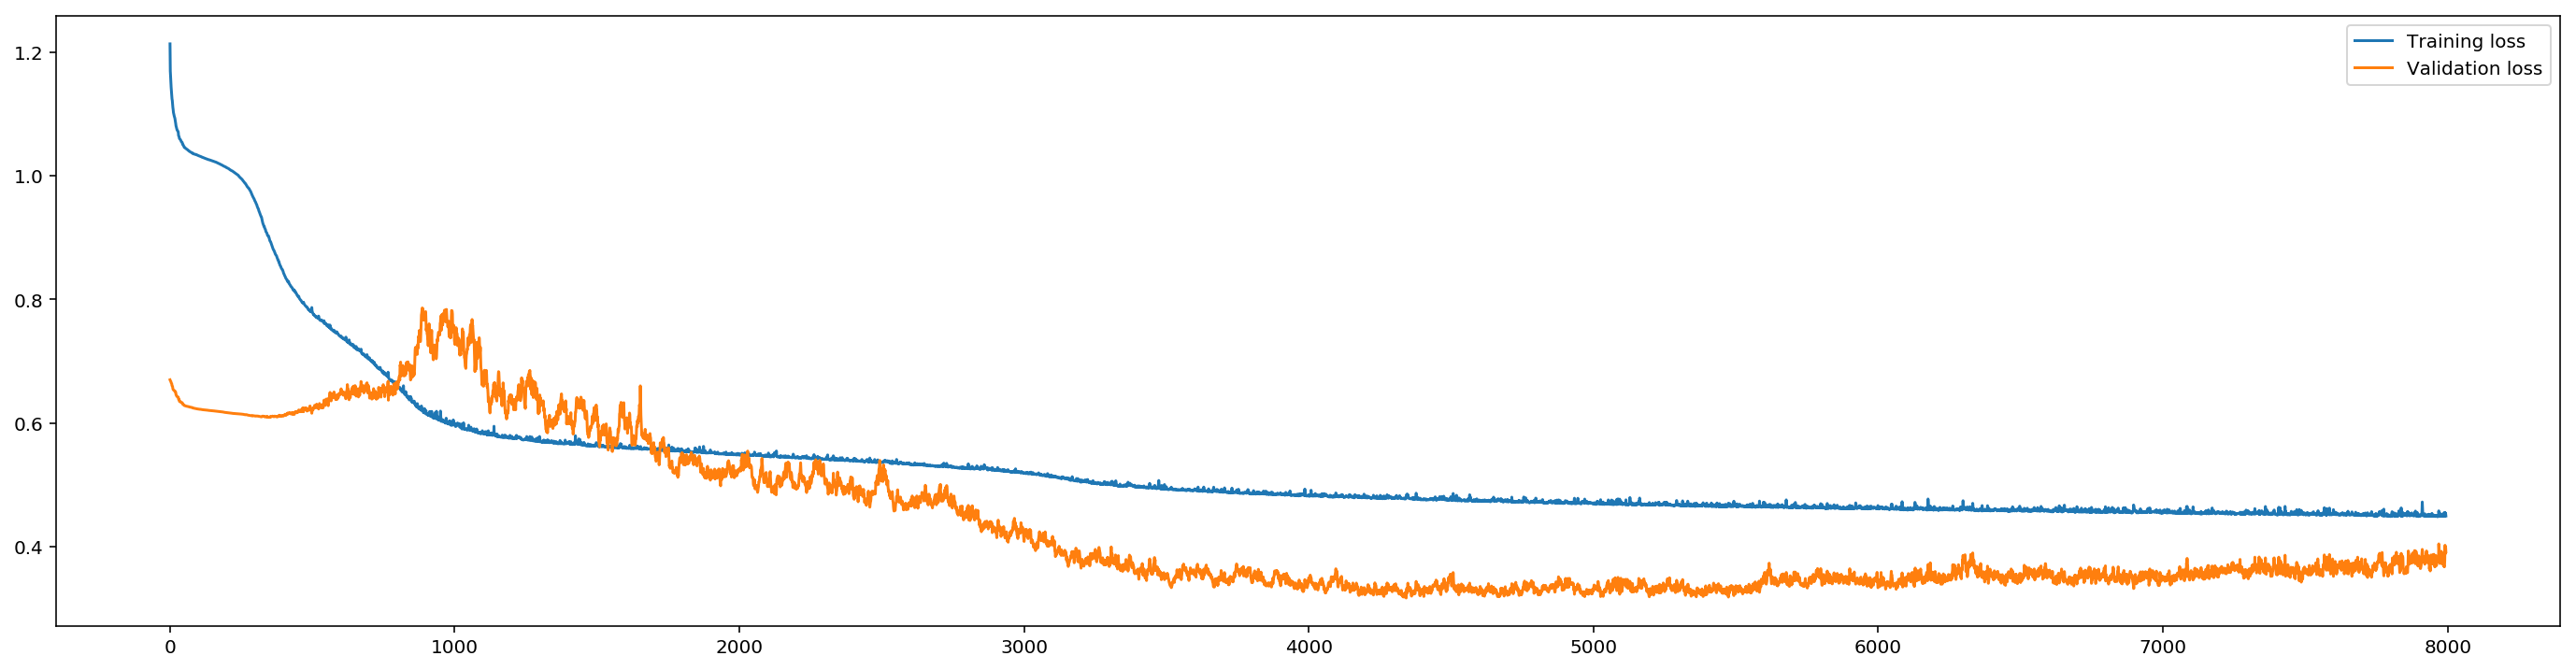

In [85]:
plt.figure(figsize=(24,6))
plt.plot(losses['train'][5:], label='Training loss')
plt.plot(losses['validation'][5:], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 4. Check out your predictions
Below are the plot of realdata and prediction data generated by network.

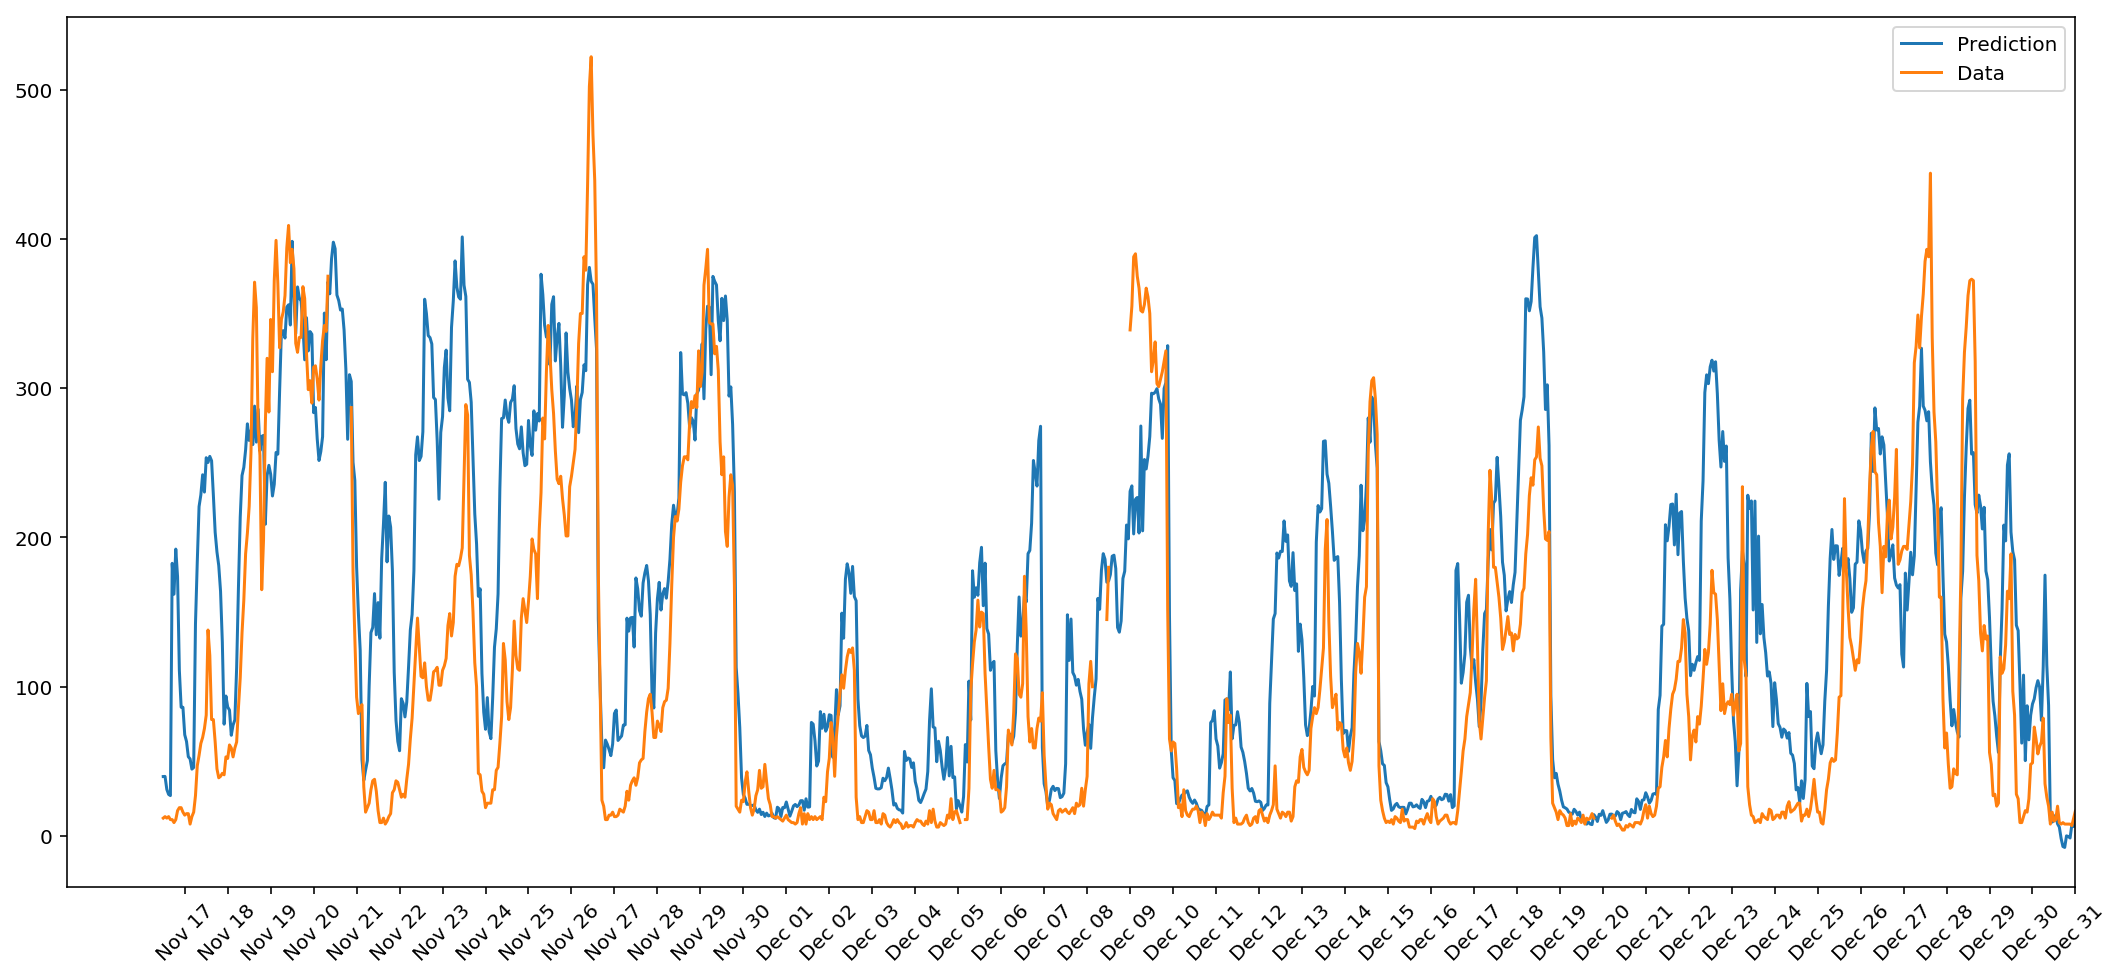

In [82]:
fig, ax = plt.subplots(figsize=(18,8))

mean, std = scaled_features['pm2.5']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['pm2.5']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(data.ix[test_data.index]['datatime'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 5. References
- http://machinelearningmastery.com/handle-missing-data-python/
- https://stats.stackexchange.com/questions/103500/machine-learning-algorithms-to-handle-missing-data